0) **Imports**

In [33]:
import os, sys
from timeit import default_timer as timer
import dolfin as df # Fenics : dolfin + ufl + FIAT + ...
import numpy as np

1) **Consititutive behaviour Definition**

Negative Flux
$$
\mathbf{q} = \alpha(|\nabla u|) \nabla u
$$

In [34]:
qL = 100.0
qT = 10.0
c1 = 6.0
c2 = 3.0
c3 = 500.0

alpha_0 = 1000.0
beta = 1e2

# Indeed negative flux for numerical reasons
def flux(g):
    g2 = df.inner(g,g)
    alpha = alpha_0*(1+beta*g2)
    return alpha*g

2) **Mesh**  

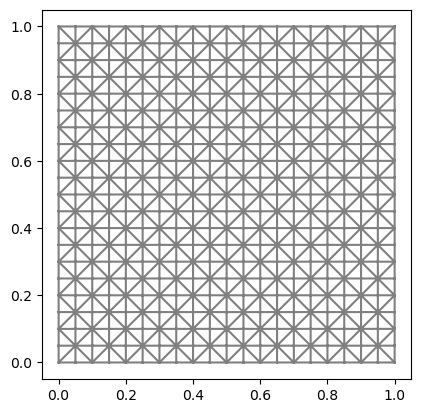

In [35]:
Nx =  20 
Ny =  20 
Lx = 1.0
Ly = 1.0
mesh = df.RectangleMesh(df.Point(0.0,0.0) , df.Point(Lx,Ly), Nx, Ny, 'left/right');
df.plot(mesh);

3) **Mesh regions** 

In [36]:
leftBnd = df.CompiledSubDomain('near(x[0], 0.0) && on_boundary')
rightBnd = df.CompiledSubDomain('near(x[0], Lx) && on_boundary', Lx=Lx)

bottomBnd = df.CompiledSubDomain('near(x[1], 0.0) && on_boundary')
topBnd = df.CompiledSubDomain('near(x[1], Ly) && on_boundary', Ly=Ly)

leftFlag = 4
rightFlag = 2
bottomFlag = 1
topFlag = 3

boundary_markers = df.MeshFunction("size_t", mesh, dim=1, value=0)
leftBnd.mark(boundary_markers, leftFlag)
rightBnd.mark(boundary_markers, rightFlag)
bottomBnd.mark(boundary_markers, bottomFlag)
topBnd.mark(boundary_markers, topFlag)


dx = df.Measure('dx', domain=mesh)
ds = df.Measure('ds', domain=mesh, subdomain_data=boundary_markers)

4) **Spaces**

In [37]:
Uh = df.FunctionSpace(mesh, "CG", 1) # Equivalent to CG
bcBottom = df.DirichletBC(Uh, df.Constant(0.0), boundary_markers, bottomFlag)
bcRight = df.DirichletBC(Uh, df.Constant(0.0), boundary_markers, rightFlag)
bcs = [bcBottom, bcRight]

5. **Variational Formulation**: Minimisation 
\begin{align} 
\min_{u \in U} \left ( J(u):=\int_{\Omega} \psi(u) dx - \Pi_{ext}(u) \right) \\
F(u; v) = \delta J(u;v) = 0 \quad \forall v \in V , \\
\delta F(u, du; v) = \delta^2 J(u, du;v) \quad \forall v \in V ,
\end{align} 
<br>


In [38]:
du = df.TrialFunction(Uh)            # Incremental displacement
v  = df.TestFunction(Uh)             # Test function
uh  = df.Function(Uh)                 # Displacement from previous iteration
x = df.SpatialCoordinate(mesh)

flux_left = df.Constant(qL)
flux_top = df.Constant(qT)
source = c3*df.sin(c1*x[0])*df.cos(c2*x[1])

P_ext = source*v*dx + flux_left*v*ds(leftFlag) + flux_top*v*ds(topFlag)
P_int = df.inner(flux(df.grad(uh)), df.grad(v))*dx

Res = P_int - P_ext

Jac = df.derivative(Res, uh, du) 

6) **Solving**

In [39]:
# Compute solution
start = timer()
df.solve(Res == 0, uh, bcs, J = Jac)
end = timer()

print("Time spent: ", end - start)
print("Norm L2: ", df.assemble(df.inner(uh,uh)*dx))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving nonlinear variational problem.
Time spent:  0.7306259200013301
Norm L2:  0.00037406497035781386
  Newton iteration 0: r (abs) = 2.263e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 6.140e+01 (tol = 1.000e-10) r (rel) = 2.713e+00 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.578e+01 (tol = 1.000e-10) r (rel) = 6.970e-01 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 2.944e+00 (tol = 1.000e-10) r (rel) = 1.301e-01 (tol = 1.000e-09)
  Newton iteration 4: r (abs) = 1.847e-01 (tol = 1.000e-10) r (rel) = 8.162e-03 (tol = 1.000e-09)
  Newton iteration 5: r (abs) = 6.487e-04 (tol = 1.000e-10) r (rel) = 2.866e-05 (tol = 1.000e-09)
  Newton iteration 6: r (abs) = 7.329e-09 (tol = 1.000e-10) r (rel) = 3.238e-10 (tol = 1.000e-09)
  Newton solver finished in 6 iterations and 6 linear solver iterations.


7. **Pos-Processing**

In [40]:
import fetricks.fenics.postprocessing.wrapper_io as iofe

Sh = df.VectorFunctionSpace(mesh, "DG", 0, dim = 2) 
gh = df.project( -df.grad(uh), Sh)
q = flux(df.grad(uh))
qh = df.project( q, Sh)

uh.rename("u",'')
gh.rename("g",'')
qh.rename("q",'')

print(np.min(gh.vector().get_local()[:].reshape((-1,2)), axis = 0))
print(np.max(gh.vector().get_local()[:].reshape((-1,2)), axis = 0))

iofe.exportXDMF_gen("square_fe_vtk.xdmf", fields={'vertex': [uh], 'cell_vector': [gh, qh] })
iofe.exportXDMF_checkpoint_gen("square_fe_sol.xdmf", fields={'vertex': [uh], 'cell': [gh, qh]})

[-0.00566646 -0.13215718]
[0.06768119 0.00817251]
